# Load system matrices as sparse-matrices
Here we use the [sparse module of scipy](
https://docs.scipy.org/doc/scipy/reference/sparse.html).
The module contains functions for linear algebra with sparse matrices (scipy.sparse.linalg).
Do **not** mix with numpy functions! Convert them to dense arrays using `.toarray()` if you need numpy.

Read system matrices as sparse matrices like this
```python
from scipy.io import mmread
from scipy.sparse import csc_matrix
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes
N = X.shape[0] # number of nodes
```

In [159]:
%pylab inline

from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import matplotlib as matplot
matplot.rcParams.update({'figure.max_open_warning': 0})

from mpl_toolkits.mplot3d import Axes3D

import sys
np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(threshold=5)

# print(matplot.__version__) #Version 2.1 needed for jsanimiation

Populating the interactive namespace from numpy and matplotlib


In [132]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes
N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

# Select nodes for application of boundary conditions and loads
We want to find all indices for nodes located on the edge of the plate.
To find all nodes on one edge we search for nodes with e.g. coordinates sufficiently close (numerical tolerance) to the minimum y-coordinate (south edge) .
Repeating this for all sides gives all edge nodes.

```python
tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.hstack([Nn,No,Ns,Nw])
```

In [133]:
tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

We can also search for the closest point to a particular location.

```python
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))
```

of for all node on the top of the plate

```python
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol)[:,0]
```

In [134]:
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol)[:,0]

# Constrain the system
We apply the clamping boundary condition on all edges by eliminating all degrees of freedom of the edge nodes from the system matrices.

```python
# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])
```

In [135]:
# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

# Compute Natural Frequencies and Mode Shapes
Use the (ARPACK) routines for sparce matrices.
```python
from scipy.sparse.linalg import eigsh
```

In [136]:
def plotmodes(V_var,W_var) :
    for i,v in enumerate(V_var.T) : # iterate over eigenvectors
        c = np.reshape(v[Iz[Nt]],[len(y),len(x)])
        lim = np.max(np.abs(c))
        fig,ax = plt.subplots(figsize=[3.5,2])
        ax.contourf(x,y,c,cmap=plt.get_cmap('RdBu'),vmin=-lim,vmax=lim)
        ax.set_aspect('equal')
        ax.set_title('Mode %i @ %f Hz'%(i+1,np.sqrt(abs(W_var[i]))/2/np.pi))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()

        
def makeFancyModes(V_var,Ic_var,W_var,Ncon) :
    for i,v in enumerate(V_var.T) :
        u = np.zeros(3*N) # initialize displacement vector
        uc = np.real(V_var[:,i]) #without exp. power term, since we only look at the static displacment
        u[~Ic_var] = uc
        
        # plot in 3D
        fig,ax = plt.subplots(subplot_kw={'projection':'3d'})    
        ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

        # format U like X
        U = np.array([u[Ix],u[Iy],u[Iz]]).T

        # scale factor for plotting
        s = 0.5/np.max(np.sqrt(np.sum(U**2,axis=0)))
        Xu = X + s*U # defomed configuration (displacement scaled by s)

        ax.scatter(Xu[:,0],Xu[:,1],Xu[:,2],s=5,c='g',label='deformed')
        ax.scatter(X[Ncon,0],X[Ncon,1],X[Ncon,2],s=50,marker='x',label='constraint')
        
        ax.set_title('Mode %i @ %f Hz'%(i+1,np.sqrt(abs(W_var[i]))/2/np.pi))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.legend()

Compute the first 10 modes and plot them.

In [7]:
# only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(Kc,k,Mc)

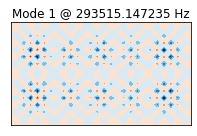

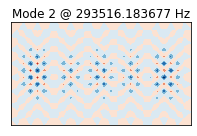

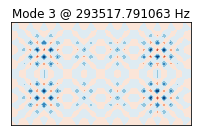

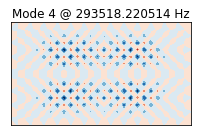

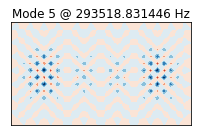

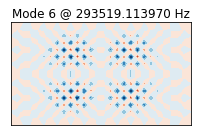

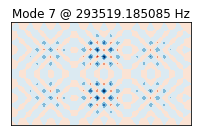

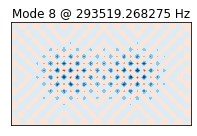

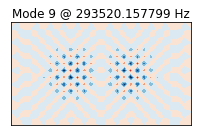

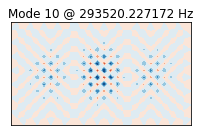

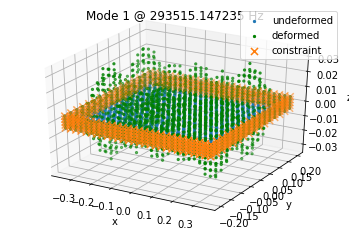

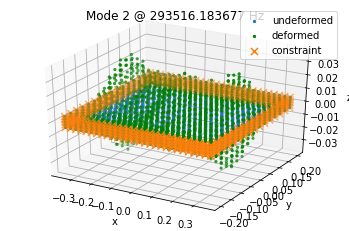

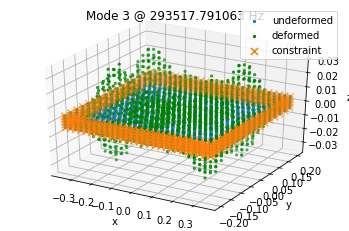

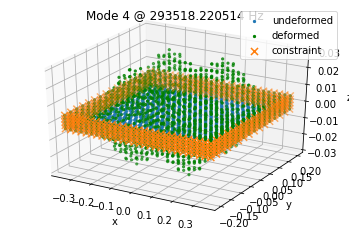

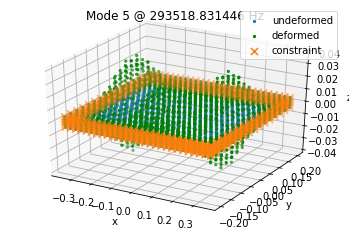

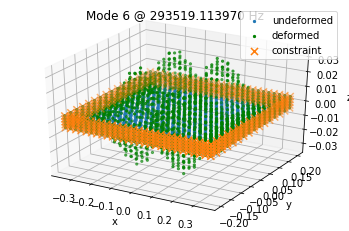

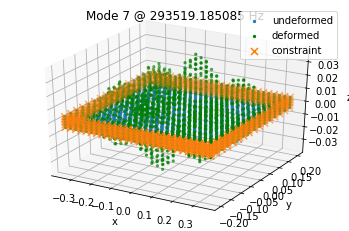

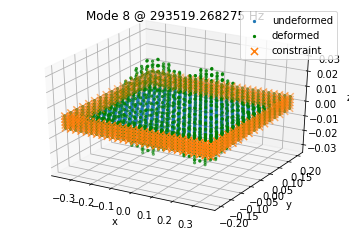

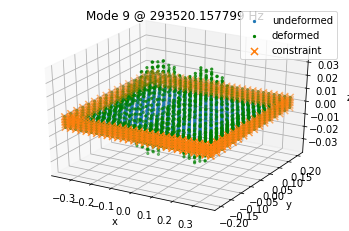

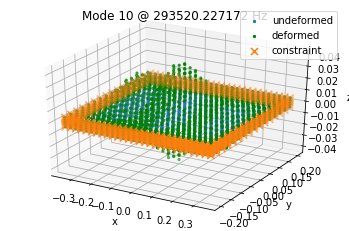

In [8]:
# add missing nodes (constraints)
V_new = np.zeros((len(Iz)*3,k))
If_sort_all = np.sort(If);

for i,v in enumerate(V.T):
    V_dat = V[:,i]
    for d,idx in enumerate(If_sort_all) :
        V_dat = np.insert(V_dat,idx,0)
    V_new[:,i] = V_dat

# do it like the prof suggested
plotmodes(V_new,W)

# # do it fancier
makeFancyModes(V,Ic,W,Nnosw)

## Aminations

You can use the excellent [JSanimation](https://github.com/jakevdp/JSAnimation) package to show matplotlib animations in a jupyter notebook.

In [9]:
import matplotlib.animation as animation

def giveMeAnimation(i,whatTOdo):
    plt.rcParams["animation.html"] = "jshtml"

    u = np.zeros(3*N) # initialize displacement vector
    uc = np.real(V[:,i]) #without exp. power term, since we only look at the static displacment
    u[~Ic] = uc

    # format U like X
    U = np.array([u[Ix],u[Iy],u[Iz]]).T

    #------------------------------------------------------------
    # set up figure and animation
    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    x, y, z = [],[],[]
    sc = ax.scatter(x,y,z,s=5,label='Mode_' + str(i))
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.04,0.04)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()

    def init():
        """initialize animation"""
        sc._offsets3d = ([],[],[])
        return sc

    def animate(i):
        # scale factor for plotting
        s = 0.5/np.max(np.sqrt(np.sum(U**2,axis=0)))*np.sin(1/25*2*np.pi*i)
        Xu = X + s*U # defomed configuration (displacement scaled by s)

        x = np.ndarray.tolist(Xu[:,0])
        y = np.ndarray.tolist(Xu[:,1])
        z = np.ndarray.tolist(Xu[:,2])

        sc._offsets3d = (x,y,z)
        return sc

    ani = animation.FuncAnimation(fig, animate, frames=50,
                                  interval=100, init_func=init)

    # # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # # installed.  The extra_args ensure that the x264 codec is used, so that
    # # the video can be embedded in html5.  You may need to adjust this for
    # # your system: for more information, see
    # # http://matplotlib.sourceforge.net/api/animation_api.html
    
    if whatTOdo == 'Save' :
        ani.save('modalanalyse_mode_' + str(i) + '.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    elif whatTOdo == 'justShow':
        plt.close()
        return ani
        

In [10]:
# %%capture
# giveMeAnimation(0,'Save')
# giveMeAnimation(1,'Save')
# giveMeAnimation(2,'Save')
# giveMeAnimation(3,'Save')
# giveMeAnimation(4,'Save')
# giveMeAnimation(5,'Save')
# giveMeAnimation(6,'Save')
# giveMeAnimation(7,'Save')
# giveMeAnimation(8,'Save')
# giveMeAnimation(9,'Save')

In [11]:
giveMeAnimation(0,'justShow')

# Additional: Make it look fancy
We implemented surfacing of the object to make it look better. Therefore, we find the top-layer, bottom-layer and all sides.

```python
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel() # Node indices of the top layer nodes
Nb = np.argwhere(np.abs(X[:,2]-X[:,2].min())<tol).ravel() # Node indices of the bottom layer nodes
```

In [89]:
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel() # Node indices of the top layer nodes
Nb = np.argwhere(np.abs(X[:,2]-X[:,2].min())<tol).ravel() # Node indices of the bottom layer nodes

ValueError: cannot reshape array of size 448 into shape (16,1)

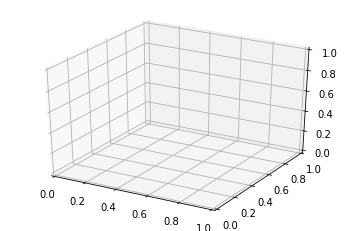

In [170]:
i = 1 #Eigenmode

u = np.zeros(3*N) # initialize displacement vector
uc = np.real(V[:,i]) #without exp. power term, since we only look at the static displacment
u[~Ic] = uc

# format U like X
U = np.array([u[Ix],u[Iy],u[Iz]]).T

fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

# # Plot a basic wireframe.
# ax.plot_wireframe(X[Nb,0], X[Nb,1], X[Nb,2], rstride=10, cstride=10)

# plt.show()


# ax.plot_wireframe(x,y,z, rstride=2, cstride=2)
# plt.show()


# grid matrices
# X_b = np.reshape(X[Nb,0],[len(x),1])
# Y_b = np.reshape(X[Nb,1],[len(x)])
# Z_b = np.reshape(X[Nb,2],[len(x)])

a = X[Nb,0]
np.reshape(a,(16,1))
# np.reshape(X[Nb,0],(28,))

# Determine useful damping
The damping ratio for each mode is computed as follows for Rayleigh damping
$$ \zeta = \frac{\alpha}{2\omega} + \frac{\beta\omega}{2} $$
Defining two frequencies $\omega_1$ and $\omega_2$ and corresponding damping ratios we can compute $\alpha$ and $\beta$.

Plot the damping ratio in the frequency range of the first 10 natural frequencies.
Choose alpha and beta such that the damping ratio is = 0.01 for mode 1 and mode 5.

# Time domain

First we investigate the system in time domain.
It should be loaded by a transient force in z-direction at point P1.

## Excitation signal
Use a smooth-step or smooth-impule function with suitable time constant.
As suitable time constant will excite interesting dynamics in the system.

The period of the first natural frequency can act as a guideline for the time constant.
If the transient excitation is very slow (it takes longer than the period of the lowest eigenfrequency to reach its maximum) there will be no significant dynamics.
If the transient excitation is very fast (pulses with frequency content covering many natural frequencies) it may excite significant dynamics.

Experiment with different excitation signals.
Plot the signal over time, and Fourier transform it to show its frequency content.

```python
from numpy.fft import rfft, rfftfreq
```

## Newmark Method for Time Integration

You the given function for time integration by the Newmark method
```python
from utlity_functions import Newmark
```

Choose a suitable time increment by considering the frequency content (highest requency) of the excitation signal.
One should use > 10 increments per period.
Select a suitable integration duration: It should cover several periods and be long enough that you see an influence of damping (assume some!).

## Task 1: Compute the transient response

Assume a load  $f(t) = 1-e^{-(t/0.002)^2}$ in z-direction at P1.
Compute the response of the plate for $0<t<0.2$ and plot the time evolution of the z-displacement at the center of the plate, at P1 and at P2.

Estimate the oscillation frequency of the system from the time signal.
How many frequencies do your see in the signal for the center point, how many in P1 and P2?
  

## Animate the transient response
Whe using JSAnimation, be careful not to animate too many time steps, since this might take a long time.

## Compare the response for different forcing functions
Investiagate how the frequency content of the excitation function impacts the output time signal.
Plot the z-displacement, e.g. at P1, over time for different excitation signals.  

# Frequency domain

## Compute the Steady-State Response

In order to compute the steady state response directly in the frequency domain, we need to
1. Compute the dynamic stiffness matrix for one $\omega$
2. assemble one (or serveral) forcing vectors
3. solve for the displacements

Use methods for sparse matrices to solve the linear system
```python
from scipy.sparse.linalg import spsolve
```

## Task 2: Transfer function
Compute the steady state response of the system to hamonic forcing in z-direction (unit amplitude) at point P1 in the frequency range from 2Hz to 300Hz (using ~150 frequency points).
Assume Rayleigh damping with $\alpha=2.15$ and $\beta=0.00003$.

Plot the response (amplitude and phase) for the z-diplacement at points P1 and P2, as well as for the center of the plate.

## Animate the harmonic response
You can use the same function as for animating mode shapes.
Look the response at characteristic frequecy points, e.g. at the peaks or minima of the transfer function. 

## Compare damping
Compute the steady state response of the system to hamonic forcing (as above) for the un-damped system, as well as for the two Rayleigh damping models mentioned above.
Compare the transfer functions for the z-displacement of P1.

## Estimate transfer function from modal data
Compute the un-damped transfer function (Receptance matrix) using the modal parameters (mode shape matrix and natural frequencies).
Compare this estimate to the transfer functions computed above.
What about the modal estimate using only 2 modes?

The recepance matrix is a large dense matrix 3N x 3N. Do not try to store it for many frequency values. Only compute and store the elements you need.